In [7]:
import numpy as np
import csv

In [8]:
labels = []

with open("data/legend.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(row[1:])
labels = np.array(labels[1:])

labels

array([['facial-expressions_2868588k.jpg', 'anger'],
       ['facial-expressions_2868585k.jpg', 'surprise'],
       ['facial-expressions_2868584k.jpg', 'disgust'],
       ...,
       ['SharmilaTagore_82.jpg', 'HAPPINESS'],
       ['SharmilaTagore_83.jpg', 'HAPPINESS'],
       ['SharmilaTagore_9.jpg', 'HAPPINESS']], dtype='<U44')

In [9]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
#label2int = {'anger': 0,
         #'surprise': 1,
         #'disgust': 2,
         #'fear': 3,
         #'neutral': 4,
         #'happiness': 5,
         #'sadness': 6,
         #'contempt': 7,
         #'NEUTRAL': 8,
         #'SADNESS': 9,
         #'DISGUST': 10,
         #'FEAR': 11,
         #'SURPRISE': 12,
         #'ANGER': 13,
         #'HAPPINESS': 14}

In [10]:
#if true, re-reads and saves all images to numpy array
if False:
    images = []
    size = (128,128)
    print("reading in images...")
    for line in tqdm(labels):
        ##read and convert to Black and White
        img = io.imread('images/'+line[0], as_grey=True)
        img = resize(img, size)
        images.append(img)
    print("saving...")
    data = np.array([images,labels[:,1]])
    np.save("data/data.npy",data)
    

In [11]:
data= np.load("data/data.npy")

		anger


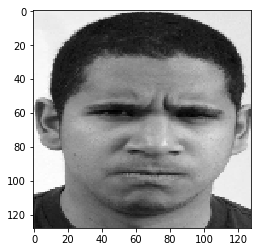

In [12]:
idx = 0
plt.imshow(data[0,idx], cmap="gray")
print("\t\t"+str(data[1,idx]))

In [40]:
labels = data[1]
images = data[0]

In [41]:
from collections import Counter
labels = [x.lower() for x in labels]
count = Counter(labels)
#print(c.most_common())
label2int = {y:x for x,(y,_) in enumerate(count.most_common())}

labels = np.array([label2int[x] for x in labels])
assert(len(labels) == len(images))
count.most_common()

[('neutral', 6868),
 ('happiness', 5696),
 ('surprise', 368),
 ('sadness', 268),
 ('anger', 252),
 ('disgust', 208),
 ('fear', 21),
 ('contempt', 9)]

In [44]:
def next_batch(labels, images, batch_size):
    for i in range(0,len(labels),batch_size):
        if i+batch_size >= len(labels):
            yield labels[i:],images[i:]
        else:
            yield labels[i:i+batch_size],images[i:i+batch_size]

In [52]:
print(images[0].shape)

(128, 128)


# Build Model

In [45]:
import tensorflow as tf

In [46]:
batch_size = 16

In [71]:
x = tf.placeholder(dtype=tf.float16, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.uint8, shape=(None),name="y")

In [72]:
y = tf.one_hot(y,len(count.most_common()))
x = tf.reshape(x,(-1,128,128,1))

In [73]:
#batch,128,128,1

#first convolution
x = tf.contrib.layers.conv2d(
    x,
    32,
    (9,9),
    stride=(1,1),
    padding='VALID',
    activation_fn=tf.nn.relu)
#batch,120,120,32

#subsample
x = tf.contrib.layers.max_pool2d(
    x,
    (4,4),
    stride=(4,4))
#batch,30,30,32

#second convolution
x = tf.contrib.layers.conv2d(
    x,
    64,
    (11,11),
    stride=(1,1),
    padding='VALID',
    activation_fn=tf.nn.relu)
#batch,20,20,64

#subsample
x = tf.contrib.layers.max_pool2d(
    x,
    (4,4),
    stride=(4,4))
#batch,5,5,64

#flatten
x = tf.contrib.layers.flatten(x)
#batch,1600

#fully connected
x = tf.contrib.layers.fully_connected(
    x,
    256,
    activation_fn=tf.nn.relu)
#batch,256

logits = tf.contrib.layers.fully_connected(
    x,
    len(count.most_common()))

In [74]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [75]:
epochs = 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        batch_i = 1
        for Y,X in next_batch(labels,images,batch_size):
            for im in Y:
                print(im)
            sess.run(optimizer,feed_dict={x:X,y:Y})
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')

4
2
5
6
0
1
0
1
1
1
0
0
1
1
0
0


ValueError: setting an array element with a sequence.